# Project Title

## Final Project for EESC G6901: Research Computing for the Earth Sciences

Code by **Caroline Juang**, c.juang@columbia.edu

Columbia University, November 2020

## Project Goals
This project is building off of my current PhD investigation into the relationship between fire and climate. In this notebook, I will explore the relationship between burned area and vapor pressure deficit (VPD). In previous research, it has been shown that a clear relationship exists between log burned area and VPD in forested ecosystems across the western US [1, 2]. To explore this relationship further, I want to ask two questions:

1. **What is the contribution of forest and non-forest ecosystems to fire in the western US?** The western US is not only made up of forests, so I want to explore the relationships of forest and non-forest ecosystems and their contribution to burn area. What areas should we be focusing on forest burn area, and what regions should focused on non-forest burn area? I hypothesize that in the prairie ecosystems in the central western US, grasslands make up a large part of the vegetation and will subsequently be affected by non-forest burn area than forested burn area.

2. **What kind of relationship exists between burn area and VPD by region?** I will explore the correlation of the 3-month burned area in each region and their associated VPD. Does this relationship change when I change the definition of the "largest fires" i.e. when I adjust the size of the upper quantile of fires included in the analysis? I hypothesize that this relationship will have higher correlation R-values in largely-forested ecosystems in the analysis of the forested burn area vs. VPD, and will be weaker in non-forest burn area vs. VPD. The relationship to emerge is likely to be more linear than exponential, since there is possibly another environmental limit to the exponential increase, like a limit in fuel or ignition that would allow the fire to continue to burn exponentially with increasing VPD.

**References**

[1]: Williams, A. P., Seager, R., Macalady, A. K., Berkelhammer, M., Crimmins, M. A., Swetnam, T. W., ... & Hryniw, N. (2015). Correlations between components of the water balance and burned area reveal new insights for predicting forest fire area in the southwest United States. International Journal of Wildland Fire, 24(1), 14-26. https://doi.org/10.1071/WF14023

[2]: Seager, R., Hooks, A., Williams, A. P., Cook, B., Nakamura, J., & Henderson, N. (2015). Climatology, variability, and trends in the US vapor pressure deficit, an important fire-related meteorological quantity. *Journal of Applied Meteorology and Climatology, 54*(6), 1121-1141. https://doi.org/10.1175/JAMC-D-14-0321.1

## Setup

In [1]:
# import
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# suppress output warnings
import warnings
warnings.simplefilter(action='ignore')

### Import the data

In [2]:
# download the datasets needed
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/wildfire/burnarea_combined.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/US_ForestType_Ruefenacht/forest_type_frac.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/ea.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/es.nc'
!wget -c 'https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/ecoregions/epa_level2.nc'

--2020-11-15 17:40:28--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/wildfire/burnarea_combined.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-11-15 17:40:28--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/landcover/US_ForestType_Ruefenacht/forest_type_frac.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 129.236.14.15
Connecting to www.ldeo.columbia.edu (www.ldeo.columbia.edu)|129.236.14.15|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-11-15 17:40:29--  https://www.ldeo.columbia.edu/~williams/US_fire/12km/climate/primary/ea.nc
Resolving www.ldeo.columbia.edu (www.ldeo.columbia.edu)... 

**The NetCDF data is imported here as 12km gridded datasets over the western United States.**
* Burn area is the monthly burned area of each grid cell (km^2) from 1984 to 2018.
* "EA" is the monthly average of vapor pressure in the atmosphere (hPa) from 1901 to 2020.
* "ES" is the monthly average of saturation vapor pressure (hPa) in the atmosphere from 1901 to 2020.
* The ecoregion data is a set of 9 gridded ecoregions that divide up the western US. One of the ecoregions is dropped because it contains no data for this region of interest. 
* Forested area is the fraction of each grid cell that is covered by 5 types of forest.

In [2]:
# import fire data and get variables
burnarea_data = xr.open_dataset('burnarea_combined.nc')
# burnarea = burnarea_data.burnarea
time_str = burnarea_data.time
X = burnarea_data.X
Y = burnarea_data.Y

# import ecoregion data
ecoregion_data = xr.open_dataset('epa_level2.nc')
# drop the bad ecoregion
ecoregion_data = ecoregion_data.sel(province=[0,1,2,3,5,6,7,8,9], drop=True)
ecoregion_legend = ecoregion_data.ecoregion
epa_l2 = ecoregion_data.epa_level2

# import forested area
forest_type_data = xr.open_dataset('forest_type_frac.nc')
ftype = forest_type_data.ftype

* After importing vapor pressure and saturation vapor pressure, we calculate vapor pressure deficit (VPD) using the following formula, where $e_s$ is saturation vapor pressure, $e_a$ is vapor pressure of the atmosphere, and $T_a$ is the temperature of the atmosphere:

VPD $ = e_s(T_a) - e_a $

In [3]:
# import vapor pressure data
ea_data = xr.open_dataset('ea.nc')
# import saturation vapor pressure data
es_data = xr.open_dataset('es.nc')

# calculate vapor pressure deficit
vpd = es_data.es - ea_data.ea

# limit dataset to the same timeframe as burnarea data
vpdcurrent = vpd.loc["1984-01-15":"2018-12-15"]

## 1. What is the contribution of forest and non-forest ecosystems to fire in the western US?

Many analyses look at forested burn area since there are clearer climate-fire signals in forested areas. Since not every region of the western US is forested due to different climate and topographic conditions, I want to see where forested burn area matters and where non-forested burned area matters.

### Get burned area in forests and not in forests
I use our fractional forest NetCDF to get the burned area associated with forest and non-forest grid cells.

In [5]:
# storage
forest = np.zeros((len(Y), len(X)), np.single)

# add up the forest percentages for each forest type
for index,number in enumerate(ftype):
    forest = forest + forest_type_data.forest_type_frac[index,:,:]

# remove forest_type_data netCDF
forest_type_data = None

# get burned area in forest
burnforest = burnarea_data * forest

In [6]:
# get non-forested burned area using fractional difference
burnxforest = burnarea_data * (1-forest)

In [7]:
# get time-sum spatial burn area
burnforesttime = burnforest.sum(dim='time')
burnxforesttime = burnxforest.sum(dim='time')

# mask the array to remove plotting where there is 0 burned area
burnforesttime2 = np.ma.masked_where(burnforesttime.burnarea.values==0, burnforesttime.burnarea)
burnxforesttime2 = np.ma.masked_where(burnxforesttime.burnarea.values==0, burnxforesttime.burnarea)

### Visualize forested and non-forested burned area

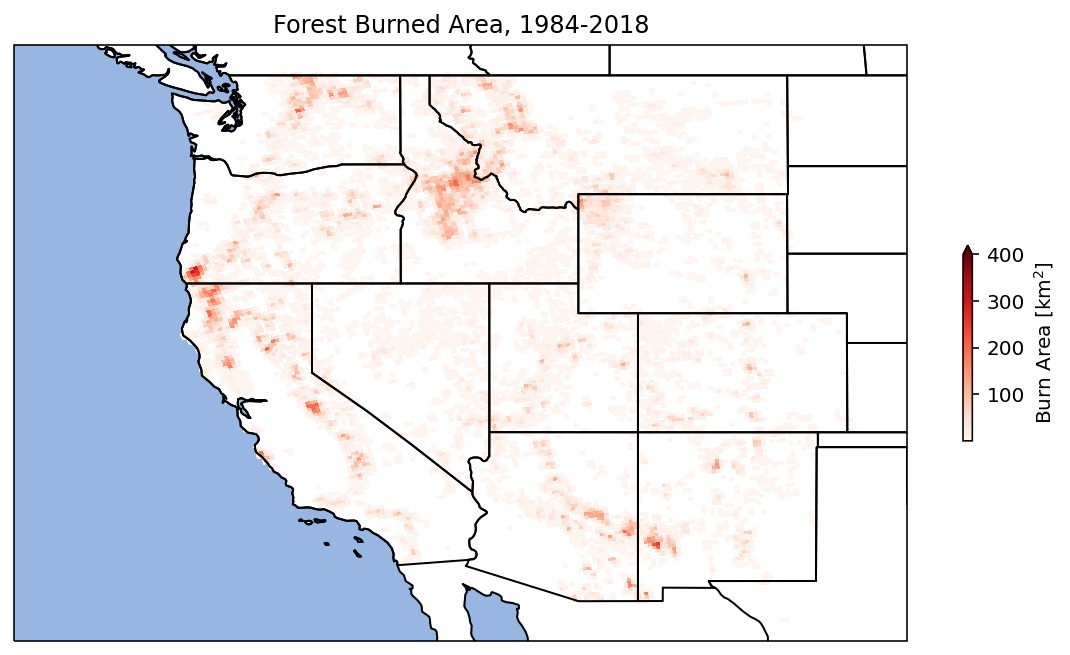

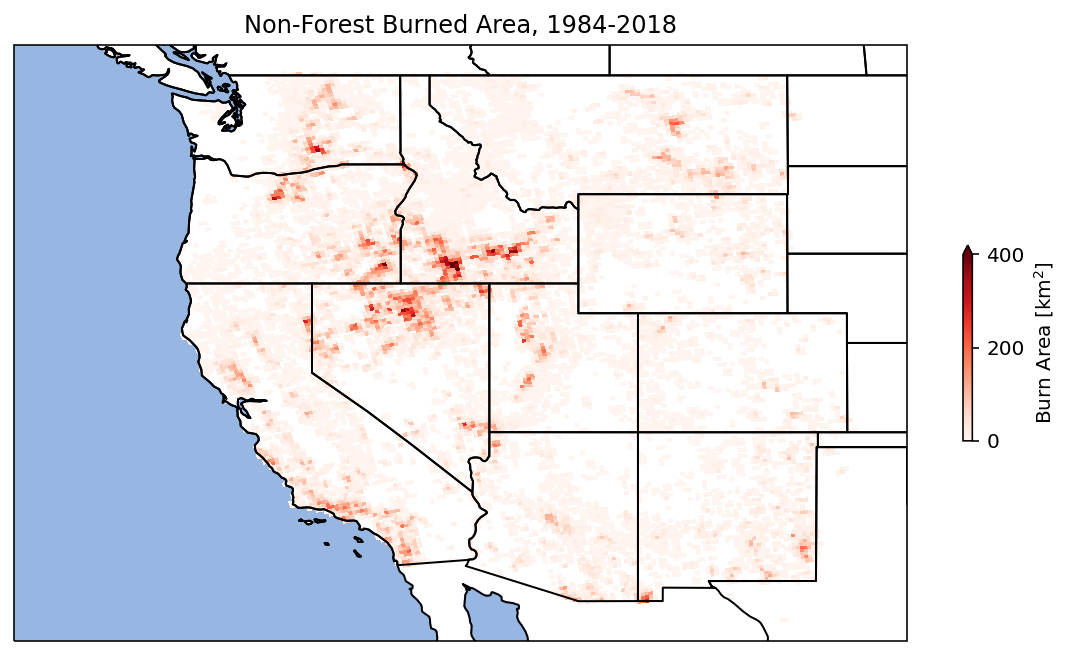

In [8]:
# visualize forested and non forested burned area

# define map extent
extent = [-130,-100,30,50]

# plot
fig, ax1 = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
# setup map
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, edgecolor='black', zorder=9)
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax1.add_feature(cfeature.OCEAN)

# plot data
burnmapfo = ax1.pcolormesh(burnforesttime.X, burnforesttime.Y, burnforesttime2, cmap='Reds', vmax=400,
                           transform=ccrs.epsg(5070))
# decorate
ax1.set_title('Forest Burned Area, 1984-2018')

bar1 = fig.colorbar(burnmapfo, ax=ax1, shrink=0.30, extend='max')
bar1.set_label('Burn Area [km$^2$]')

# plot 
fig, ax2 = plt.subplots(figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree()})
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, edgecolor='black', zorder=9)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax2.add_feature(cfeature.OCEAN)

# plot data
burnmapxfo = ax2.pcolormesh(burnxforesttime.X, burnxforesttime.Y, burnxforesttime2, cmap='Reds', vmax=400,
                            transform=ccrs.epsg(5070))
# decorate
ax2.set_title('Non-Forest Burned Area, 1984-2018')
bar2 = fig.colorbar(burnmapxfo, ax=ax2, shrink=0.30, extend='max')
bar2.set_label('Burn Area [km$^2$]')

### Visualize (coarse) annual burned area

In [9]:
# resample to get burned area by year
burnforest_all = burnarea_data.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])
burnforest_y = burnforest.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])
burnxforest_y = burnxforest.resample(indexer={'time':'Y'}).sum().sum(dim=['X','Y'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


In [10]:
# setup
# years in dataset
yrmin = 1984
yrmax = 2018

# make list of years
years = np.arange(yrmin, yrmax+1)
months = np.arange(1,12+1) # months
nyears = yrmax-yrmin

In [11]:
# make DataFrame of the annual burn area for plotting
df = pd.DataFrame({'years': years, 'forest': burnforest_y.burnarea.values, 
                   'non-forest': burnxforest_y.burnarea.values, 
                   'all burn area': burnforest_all.burnarea.values})

In [12]:
# calculate the linear line of best fit
burnallm, burnallb = np.polyfit(df.years, df['all burn area'], 1)
burnfom, burnfob = np.polyfit(df.years, df.forest, 1)
burnxfom, burnxfob = np.polyfit(df.years, df['non-forest'], 1)

(1984.0, 2018.0)

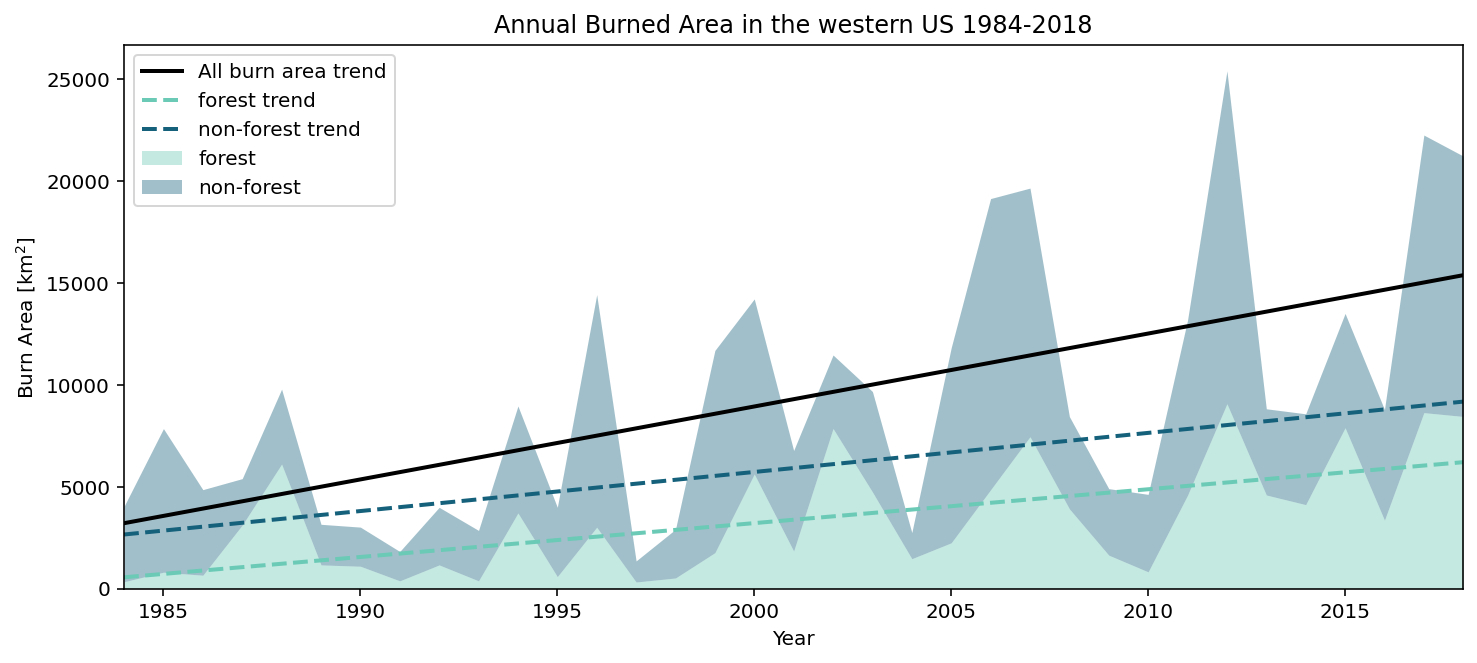

In [13]:
# colors
palette = ['#6bcab6', '#15617c']

# plot data
fig, ax = plt.subplots(figsize=(12,5))
df.plot.area(x='years', y=['forest','non-forest'], color=palette, alpha=0.4, linewidth=0, ax=ax)

# plot line of best fit
ax.plot(years, (burnallm*years + burnallb), color='k', linewidth=2, label='All burn area trend')
ax.plot(years, (burnfom*years + burnfob), '--', color=palette[0], linewidth=2, label='forest trend')
ax.plot(years, (burnxfom*years + burnxfob), '--', color=palette[1], linewidth=2, label='non-forest trend')

# decorate
ax.legend(loc='upper left')
ax.set_title('Annual Burned Area in the western US 1984-2018')
ax.set_ylabel('Burn Area [km$^2$]')
ax.set_xlabel('Year');
ax.set_xlim([1984,2018])

## Relationship of Burn Area and Vapor Pressure Deficit (VPD) by Region

### Break down by Ecoregion

In [14]:
epa_l2

<xarray.DataArray 'epa_level2' (province: 9, Y: 208, X: 155)>
[290160 values with dtype=float32]
Coordinates:
  * X        (X) float64 -2.353e+06 -2.341e+06 ... -5.172e+05 -5.052e+05
  * Y        (Y) float64 3.172e+06 3.16e+06 3.148e+06 ... 6.995e+05 6.875e+05
Dimensions without coordinates: province
Attributes:
    long_name:  fraction of grid cell within each EPA level-2 ecoregion
    units:      unitless

In [15]:
ecoregion_legend.legend

'1: COLD DESERTS, 2: MARINE WEST COAST FOREST, 3: MEDITERRANEAN CALIFORNIA, 4: SOUTH CENTRAL SEMIARID PRAIRIES, 5: TEMPERATE PRAIRIES, 6: UPPER GILA MOUNTAINS, 7: WARM DESERTS, 8: WEST-CENTRAL SEMIARID PRAIRIES, 9: WESTERN CORDILLERA, 10: WESTERN SIERRA MADRE PIEDMONT'

### Get burned area yearly

In [16]:
# create container for month sums of burned area
month_burnfo = np.zeros((len(time_str), len(epa_l2)))
month_burnxfo = np.zeros((len(time_str), len(epa_l2)))

# get monthly burned data by region
for index, region in enumerate(epa_l2):
    tmpburnarea_fo = burnforest.burnarea * region
    tmpburnarea_xfo = burnxforest.burnarea * region
    month_burnfo[:, index] = tmpburnarea_fo.sum(dim=('Y','X'))
    month_burnxfo[:, index] = tmpburnarea_xfo.sum(dim=('Y','X'))
    
# create new DataArrays
month_burnfo = xr.DataArray(month_burnfo, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])
month_burnxfo = xr.DataArray(month_burnxfo, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])

In [17]:
# check out monthly rolling fire threshold in burn area by month
burnfomoroll = month_burnfo.rolling(time=3).sum()
burnxfomoroll = month_burnxfo.rolling(time=3).sum()

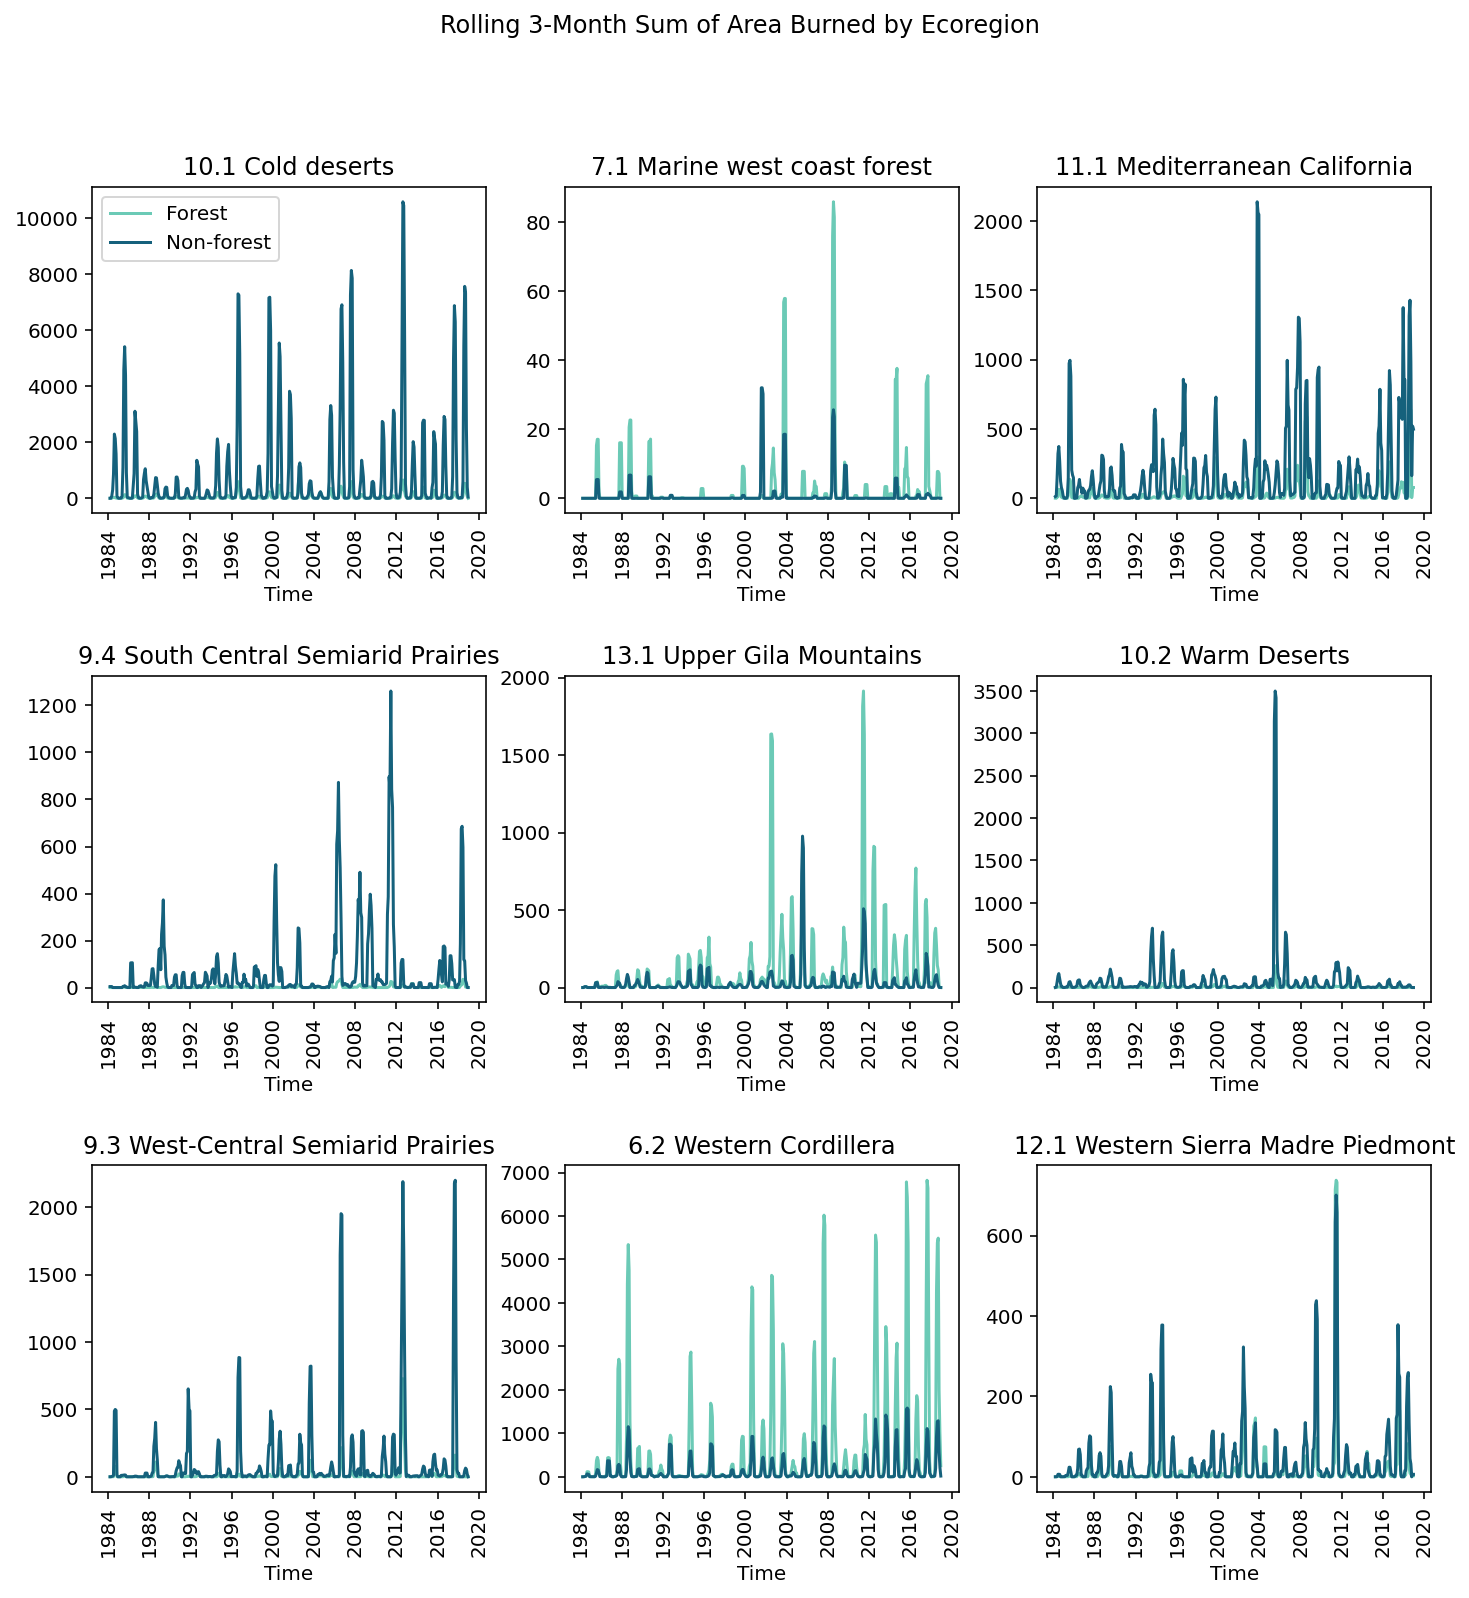

In [18]:
# plot the monthly rolling fire threshold for forested area

# plot
fig, ax = plt.subplots(3,3, figsize=(12,12))

counter = 0
for index in range(0,3):
    for jndex in range(0,3):
        ax[index,jndex].plot(burnfomoroll.time, burnfomoroll.isel(ecoregion=counter), color=palette[0], zorder=2, label='Forest')
        ax[index, jndex].plot(burnxfomoroll.time, burnxfomoroll.isel(ecoregion=counter), color=palette[1], zorder=3, label='Non-forest')
        counter+=1
        
# decorate plots
ax[0,0].set_title('10.1 Cold deserts')
ax[0,1].set_title('7.1 Marine west coast forest')
ax[0,2].set_title('11.1 Mediterranean California')
ax[1,0].set_title('9.4 South Central Semiarid Prairies')
ax[1,1].set_title('13.1 Upper Gila Mountains')
ax[1,2].set_title('10.2 Warm Deserts')
ax[2,0].set_title('9.3 West-Central Semiarid Prairies')
ax[2,1].set_title('6.2 Western Cordillera')
ax[2,2].set_title('12.1 Western Sierra Madre Piedmont')

# iterate and plot labels
for index in range(0,3):
    for jndex in range(0,3):
        plt.setp(ax[index,jndex].get_xticklabels(), rotation=90, horizontalalignment='center')
        ax[index,jndex].set_xlabel('Time')
        ax[index,jndex].set_ylabel('')
        
ax[0,0].legend(loc='upper left')
plt.suptitle('Rolling 3-Month Sum of Area Burned by Ecoregion')
plt.subplots_adjust(hspace = 0.5)

### Define threshold, and get associated VPD with Forest and Non-Forest

In [201]:
# get monthly VPD by region

# preallocate storage
month_vpd = np.zeros((len(time_str), len(epa_l2)))

# get monthly average
for index, region in enumerate(epa_l2):
    # area-weighted average
    # sum(new adjusted climate values)/sum(sum of all values in region map) 
    tmpvar = vpdcurrent * region
    month_vpd[:, index] = tmpvar.sum(dim=('Y','X')) / region.sum()
    
# create new DataArray
month_vpd = xr.DataArray(month_vpd, coords=[time_str, ecoregion_legend], dims=['time', 'ecoregion'])

In [202]:
# get quantile of fires for each region
quanvalue = 0.75
# check out monthly rolling fire threshold in burn area by month
tmpquantfo = burnfomoroll.where(burnfomoroll > 0).quantile(quanvalue, dim='time')
tmpquantxfo = burnfomoroll.where(burnfomoroll > 0).quantile(quanvalue, dim='time')

# use quantile to create a mask for the dataset
# iterate through the dataset
tmpmaskfo = burnfomoroll >= tmpquantfo
tmpmaskxfo = burnxfomoroll >= tmpquantxfo

In [203]:
# get masked burn area
tmpburnfo = burnfomoroll.where(tmpmaskfo, drop=True)
tmpburnxfo = burnxfomoroll.where(tmpmaskxfo, drop=True)

# get masked vpd
tmpvpdfo = month_vpd.where(tmpmaskfo, drop=True)
tmpvpdxfo = month_vpd.where(tmpmaskxfo, drop=True)

#tmpburnyrfo = burnfomoroll.where(tmpmaskfo).resample(indexer={'time':'Y'}).sum()
#tmpburnyrxfo = burnxfomoroll.where(tmpmaskfo).resample(indexer={'time':'Y'}).sum()

# get masked vpd
#tmpvpdyrfo = month_vpd.where(tmpmaskfo).resample(indexer={'time':'Y'}).mean(skipna=True)
#tmpvpdyrxfo = month_vpd.where(tmpmaskxfo).resample(indexer={'time':'Y'}).mean(skipna=True)

In [216]:
# get correlation of VPD and burned area
# storage
corrfo = np.zeros((len(epa_l2)))
sigfo = np.zeros((len(epa_l2)))
corrxfo = np.zeros((len(epa_l2)))
sigxfo = np.zeros((len(epa_l2)))

# get the line of best fit for the graphs
# storage for parameters
mfo = np.zeros((len(epa_l2)))
bfo = np.zeros((len(epa_l2)))
mxfo = np.zeros((len(epa_l2)))
bxfo = np.zeros((len(epa_l2)))

for index, region in enumerate(epa_l2):
    # forest
    tmpvpd = tmpvpdfo[:, index].dropna(dim='time')
    tmpburn = tmpburnfo[:, index].dropna(dim='time')
    tmpstats = scipy.stats.pearsonr(tmpvpd, tmpburn)
    corrfo[index] = tmpstats[0]
    sigfo[index] = tmpstats[1]
    mfo[index], bfo[index] = np.polyfit(tmpvpd, tmpburn, 1)
    # non-forest
    tmpvpd = tmpvpdxfo[:, index].dropna(dim='time')
    tmpburn = tmpburnxfo[:, index].dropna(dim='time')
    tmpstats = scipy.stats.pearsonr(tmpvpd, tmpburn)
    corrxfo[index] = tmpstats[0]
    sigxfo[index] = tmpstats[1]
    mxfo[index], bxfo[index] = np.polyfit(tmpvpd, tmpburn, 1)

# store values in regional correlations
# define storage for correlation by region
#corr_vpd[jndex,:] = corr
#corrsig_vpd[jndex,:] = sig

In [217]:
# get significance of forest and non-forest correlations
print(sigfo)
print('\n')
print (sigxfo)

[4.75568360e-04 9.19898858e-01 1.06020325e-01 1.44010323e-03
 7.02651312e-03 4.06712855e-01 1.13954000e-02 1.49248073e-03
 1.58580221e-01]


[6.77921925e-04 2.55161942e-01 2.93546503e-01 3.02956740e-08
 1.11604829e-01 1.26495941e-03 1.66246868e-05 9.84339891e-01
 6.27063867e-04]


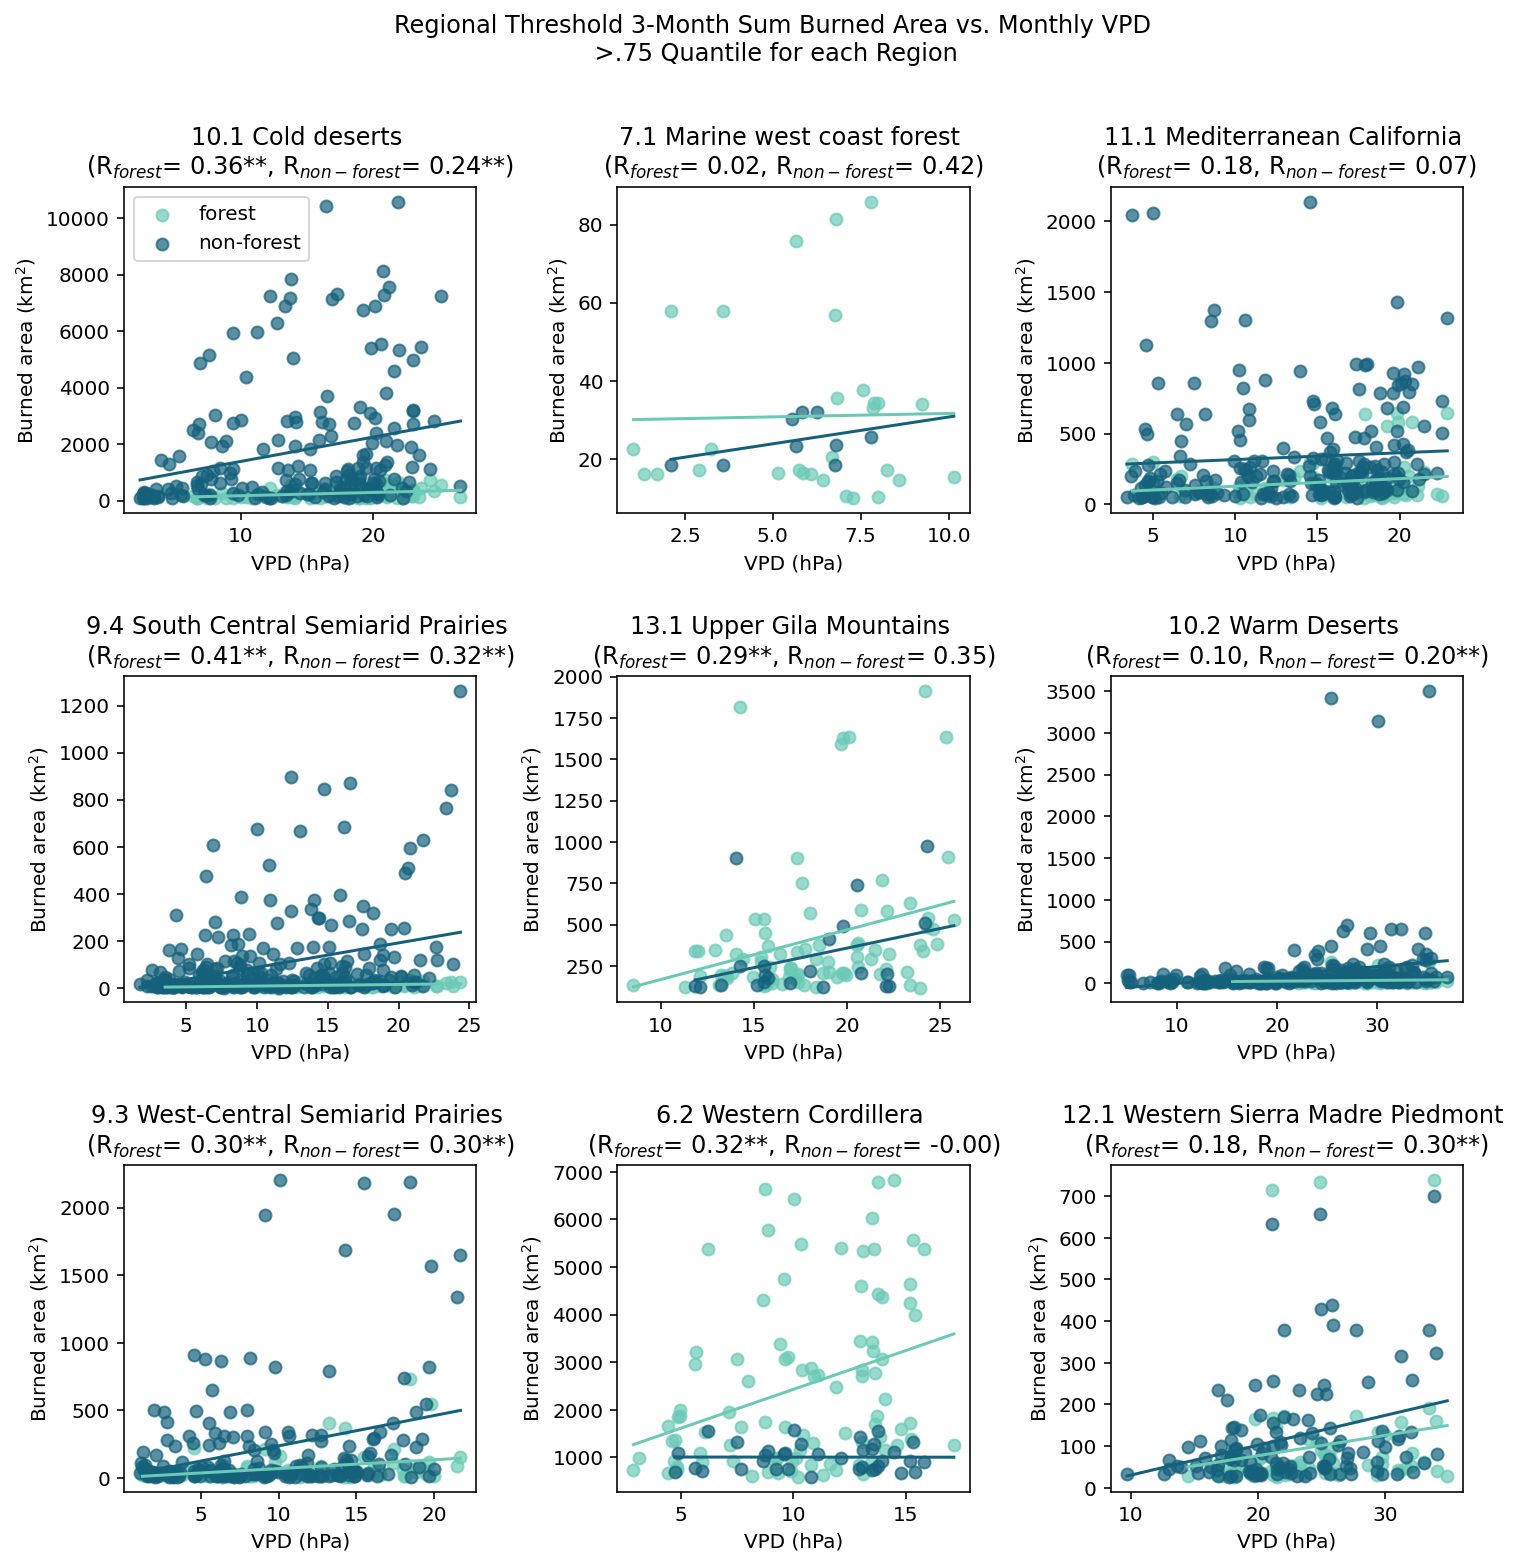

In [218]:
# graph the values

# plot the graph

# plot
fig, ax = plt.subplots(3,3, figsize=(12, 12))

counter = 0
for index in range(0,3):
    for jndex in range(0,3):
        tmpvpd = tmpvpdfo[:, counter].dropna(dim='time')
        tmpburn = tmpburnfo[:, counter].dropna(dim='time')
        tmpvpd2 = tmpvpdxfo[:, counter].dropna(dim='time')
        tmpburn2 = tmpburnxfo[:, counter].dropna(dim='time')
        # create linspace to graph the trendlines
        tmpline = np.linspace(tmpvpd.min(), tmpvpd.max(), 100)
        tmpline2 = np.linspace(tmpvpd2.min(), tmpvpd.max(), 100)
        # plot
        ax[index,jndex].scatter(tmpvpd, tmpburn, color=palette[0], alpha=0.7, label='forest')
        ax[index,jndex].plot(tmpline, (tmpline*mfo[counter] + bfo[counter]), color=palette[0])
        ax[index,jndex].scatter(tmpvpd2, tmpburn2, color=palette[1], alpha=0.7, label='non-forest')
        ax[index,jndex].plot(tmpline2, (tmpline2*mxfo[counter] + bxfo[counter]), color=palette[1])
        counter += 1

# decorate

ax[0,0].set_title('10.1 Cold deserts \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[0], corrxfo[0]))
ax[0,1].set_title('7.1 Marine west coast forest \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[1], corrxfo[1]))
ax[0,2].set_title('11.1 Mediterranean California \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[2], corrxfo[2]))
ax[1,0].set_title('9.4 South Central Semiarid Prairies \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[3], corrxfo[3]))
ax[1,1].set_title('13.1 Upper Gila Mountains \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f)' % (corrfo[4], corrxfo[4]))
ax[1,2].set_title('10.2 Warm Deserts \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f**)' % (corrfo[5], corrxfo[5]))
ax[2,0].set_title('9.3 West-Central Semiarid Prairies \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f**)' % (corrfo[6], corrxfo[6]))
ax[2,1].set_title('6.2 Western Cordillera \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f)' % (corrfo[7], corrxfo[7]))
ax[2,2].set_title('12.1 Western Sierra Madre Piedmont \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f**)' % (corrfo[8], corrxfo[8]))

for index in range(0,3):
    for jndex in range(0,3):
        ax[index, jndex].set_ylabel('Burned area (km$^2$)')
        ax[index, jndex].set_xlabel('VPD (hPa)')

ax[0,0].legend(loc='upper left')
plt.suptitle('Regional Threshold 3-Month Sum Burned Area vs. Monthly VPD\n >.75 Quantile for each Region')
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.4)

In [220]:
# repeat the same experiment but instead see yearly burn area sum and VPD average

tmpburnyrfo = burnfomoroll.where(tmpmaskfo, drop=True).resample(indexer={'time':'Y'}).sum()
tmpburnyrxfo = burnxfomoroll.where(tmpmaskfo, drop=True).resample(indexer={'time':'Y'}).sum()

# get masked vpd
tmpvpdyrfo = month_vpd.where(tmpmaskfo, drop=True).resample(indexer={'time':'Y'}).mean(skipna=True)
tmpvpdyrxfo = month_vpd.where(tmpmaskxfo, drop=True).resample(indexer={'time':'Y'}).mean(skipna=True)

In [221]:
# get correlation of VPD and burned area
# storage
corrfo = np.zeros((len(epa_l2)))
sigfo = np.zeros((len(epa_l2)))
corrxfo = np.zeros((len(epa_l2)))
sigxfo = np.zeros((len(epa_l2)))

# get the line of best fit for the graphs
# storage for parameters
mfo = np.zeros((len(epa_l2)))
bfo = np.zeros((len(epa_l2)))
mxfo = np.zeros((len(epa_l2)))
bxfo = np.zeros((len(epa_l2)))

for index, region in enumerate(epa_l2):
    # forest
    tmpvpd = tmpvpdyrfo[:, index].dropna(dim='time')
    tmpburn = tmpburnyrfo[:, index].where(~np.isnan(tmpvpdyrfo[:, index])).dropna(dim='time')
    tmpstats = scipy.stats.pearsonr(tmpvpd, tmpburn)
    corrfo[index] = tmpstats[0]
    sigfo[index] = tmpstats[1]
    mfo[index], bfo[index] = np.polyfit(tmpvpd, tmpburn, 1)
    # non-forest
    tmpvpd = tmpvpdyrxfo[:, index].dropna(dim='time')
    tmpburn = tmpburnyrxfo[:, index].where(~np.isnan(tmpvpdyrxfo[:, index])).dropna(dim='time')
    tmpstats = scipy.stats.pearsonr(tmpvpd, tmpburn)
    corrxfo[index] = tmpstats[0]
    sigxfo[index] = tmpstats[1]
    mxfo[index], bxfo[index] = np.polyfit(tmpvpd, tmpburn, 1)

# store values in regional correlations
# define storage for correlation by region
#corr_vpd[jndex,:] = corr
#corrsig_vpd[jndex,:] = sig

In [222]:
# significance for forested burn area vs. VPD correlation
print(sigfo)

[0.09040416 0.78971323 0.61659303 0.73860632 0.088941   0.59472581
 0.284552   0.25480915 0.26487628]


In [223]:
# significance for non-forested burn area vs. VPD correlation
print(sigxfo)

[0.75131179 0.95805181 0.88874995 0.41777426 0.59262906 0.04124918
 0.12768584 0.44850349 0.62611797]


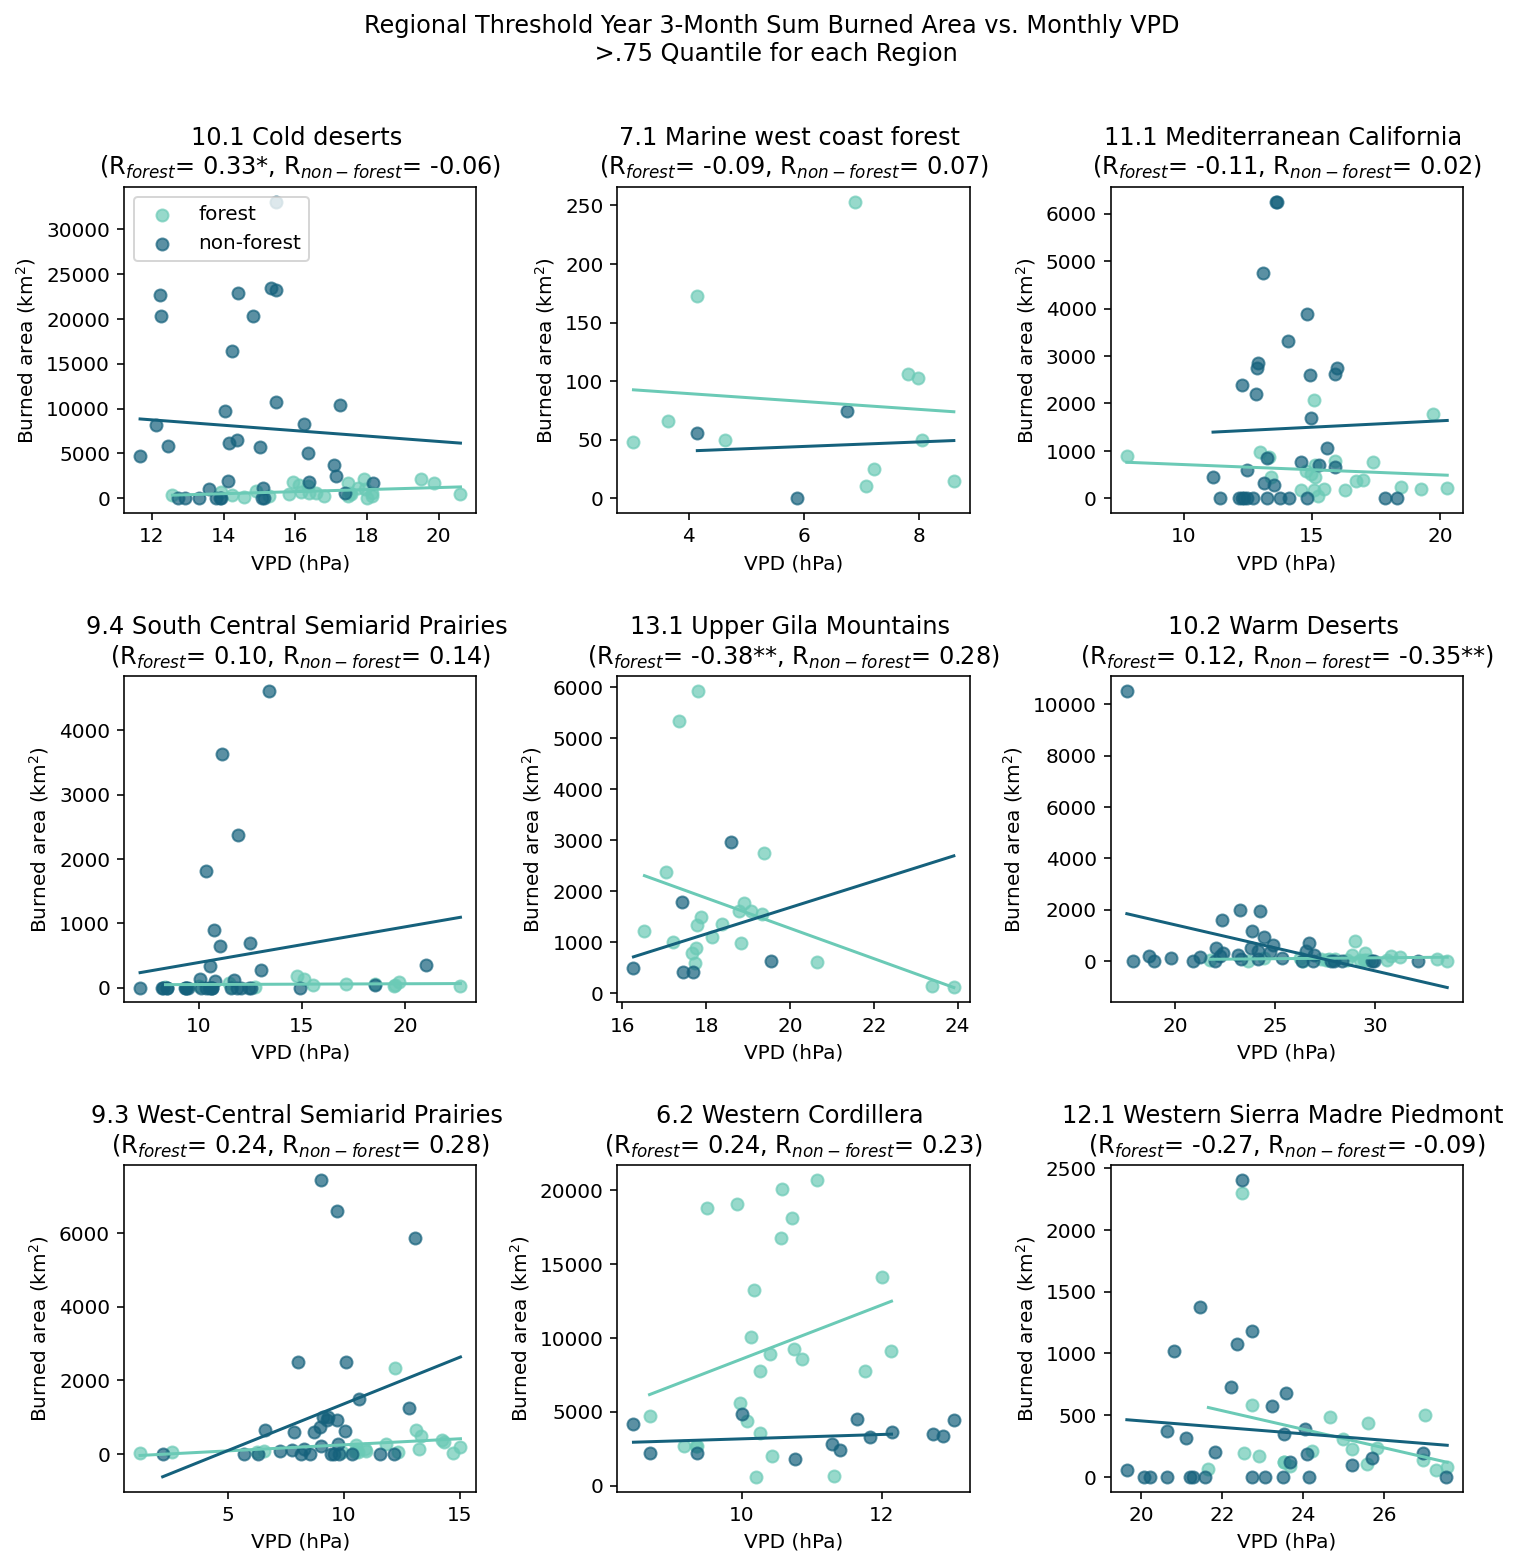

In [224]:
# graph the values

# plot the graph

# plot
fig, ax = plt.subplots(3,3, figsize=(12, 12))

counter = 0
for index in range(0,3):
    for jndex in range(0,3):
        tmpvpd = tmpvpdyrfo[:, counter].dropna(dim='time')
        tmpburn = tmpburnyrfo[:, counter].where(~np.isnan(tmpvpdyrfo[:, counter])).dropna(dim='time')
        tmpvpd2 = tmpvpdyrxfo[:, counter].dropna(dim='time')
        tmpburn2 = tmpburnyrxfo[:, counter].where(~np.isnan(tmpvpdyrxfo[:, counter])).dropna(dim='time')
        # create linspace to graph the trendlines
        tmpline = np.linspace(tmpvpd.min(), tmpvpd.max(), 100)
        tmpline2 = np.linspace(tmpvpd2.min(), tmpvpd.max(), 100)
        # plot
        ax[index,jndex].scatter(tmpvpd, tmpburn, color=palette[0], alpha=0.7, label='forest')
        ax[index,jndex].plot(tmpline, (tmpline*mfo[counter] + bfo[counter]), color=palette[0])
        ax[index,jndex].scatter(tmpvpd2, tmpburn2, color=palette[1], alpha=0.7, label='non-forest')
        ax[index,jndex].plot(tmpline2, (tmpline2*mxfo[counter] + bxfo[counter]), color=palette[1])
        counter += 1

# decorate

ax[0,0].set_title('10.1 Cold deserts \n(R$_{forest}$= %.2f*, R$_{non-forest}$= %.2f)' % (corrfo[0], corrxfo[0]))
ax[0,1].set_title('7.1 Marine west coast forest \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[1], corrxfo[1]))
ax[0,2].set_title('11.1 Mediterranean California \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[2], corrxfo[2]))
ax[1,0].set_title('9.4 South Central Semiarid Prairies \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[3], corrxfo[3]))
ax[1,1].set_title('13.1 Upper Gila Mountains \n(R$_{forest}$= %.2f**, R$_{non-forest}$= %.2f)' % (corrfo[4], corrxfo[4]))
ax[1,2].set_title('10.2 Warm Deserts \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f**)' % (corrfo[5], corrxfo[5]))
ax[2,0].set_title('9.3 West-Central Semiarid Prairies \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[6], corrxfo[6]))
ax[2,1].set_title('6.2 Western Cordillera \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[7], corrxfo[7]))
ax[2,2].set_title('12.1 Western Sierra Madre Piedmont \n(R$_{forest}$= %.2f, R$_{non-forest}$= %.2f)' % (corrfo[8], corrxfo[8]))

for index in range(0,3):
    for jndex in range(0,3):
        ax[index, jndex].set_ylabel('Burned area (km$^2$)')
        ax[index, jndex].set_xlabel('VPD (hPa)')

ax[0,0].legend(loc='upper left')
plt.suptitle('Regional Threshold Year 3-Month Sum Burned Area vs. Monthly VPD\n >.75 Quantile for each Region')
plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.4)